In [131]:
from typing import Iterator
from torch.nn.parameter import Parameter
import torch.nn as nn
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from algorithm.fedprob_utils.smooth import Smooth
import utils.fflow as flw
import torch
import multiprocessing
import pickle
import matplotlib.pyplot as plt
import ujson
import random
import json
import pickle as pk

# Settings
fedtask = "cifar10_cnum100_dist10_skew0.1_seed0"
record_path = '/mnt/disk1/naver/hieunguyen/provably_fl/fedtask/cifar10_cnum100_dist10_skew0.1_seed0/record/fedprob_N_0.25Mresnet18_R600_B10_E5_LR0.0500_P0.10_S0_LD-0.002_WD0.000_DR0.00_AC99999.00.json'
# model_path = '/mnt/disk1/naver/hieunguyen/provably_fl/fedtask/cifar10_cnum100_dist8_skew0.1_seed0/record/fedprob_N_0.25Mresnet18_R300_B10_E5_LR0.0500_P0.10_S0_LD-0.002_WD0.000_DR0.00_AC99999.00.json.pkl'
record = json.load(open(record_path, "r", encoding="utf-8"))
options = record['meta']

In [132]:
options['gpu'] = 2
options['server_gpu_id'] = 2

In [133]:
# load server
# read options
os.environ['MASTER_ADDR'] = "localhost"
os.environ['MASTER_PORT'] = '8888'
os.environ['WORLD_SIZE'] = str(3)
# set random seed
flw.setup_seed(options['seed'])
# initialize server
server = flw.initialize(options)

init fedtask...done
init clients...done
init server...done


In [134]:
import copy
model_pool = []
for client in tqdm(server.clients):
    model = copy.deepcopy(server.model)
    # model = model.to("cuda:1")
    client.train(model)
    model = model.to('cpu')
    model_pool.append(model)

100%|██████████| 100/100 [06:26<00:00,  3.86s/it]


In [135]:
server.model = server.model.to('cpu')

In [136]:
fc_weight_pool = []
for model in model_pool:
    fc_weight, fc_bias = [param for param in model.fc.parameters()]
    fc_weight_concat = torch.concat([fc_weight, fc_bias.unsqueeze(-1)], dim=1)
    fc_weight_pool.append(fc_weight_concat)
    
server_fc_weight, server_fc_bias = [param for param in server.model.fc.parameters()]
server_fc_weight = torch.concat([server_fc_weight, server_fc_bias.unsqueeze(-1)], dim=1)

In [137]:
clien_fc_gradient = []
for client_fc_weight in fc_weight_pool:
    fc_layer_gradient = client_fc_weight - server_fc_weight
    clien_fc_gradient.append(fc_layer_gradient)

In [138]:
client_similarity = torch.zeros(size=(100, 100))
# for i in range(100):

flat_client_gradient = []
for client_gradient in clien_fc_gradient:
    flat_client_gradient.append(client_gradient.flatten())
    
for i, flat_grad_i in enumerate(flat_client_gradient):
    for j, flat_grad_j in enumerate(flat_client_gradient):
        client_similarity[i, j] = torch.nn.functional.cosine_similarity(flat_grad_i, flat_grad_j, dim=0)
        

In [139]:
# assert False, "Gradient ending from here"

In [140]:
num_classes = 10
num_clients = 100 

In [141]:
server_labels = []
client_labels = {}
num_client = 0
client_class_num = np.zeros((num_classes,))
cnum_client = []

for X, Y in server.test_data:
    server_labels.append(Y)
for client in server.clients:
    client_labels[client.name] = []
    for X, Y in client.train_data:
        client_labels[client.name].append(Y.item())
    num_client += len(client_labels[client.name])
    class_num, bins = np.histogram(client_labels[client.name], range=[0, num_classes], bins=range(num_classes + 1))
    
    cnum_client.append(class_num)
    client_class_num += class_num

num_server = len(server_labels)

server_class_num, bins = np.histogram(server_labels)

In [142]:
PD = np.array(cnum_client)
PD = PD / PD.sum(axis=0)
PS = server_class_num / server_class_num.sum()
PS = torch.Tensor(PS)
client_num = np.array(cnum_client).sum(axis=1) / np.sum(np.array(cnum_client))
client_num = torch.Tensor(client_num)

In [143]:
client_server_sim = torch.zeros((100, 1))
for i in range(num_clients):
    PDi = torch.Tensor(PD[i])
    client_server_sim[i] = torch.nn.functional.cosine_similarity(PDi, PS, dim=0)

In [144]:
w = torch.linalg.solve(client_similarity, client_server_sim)

In [145]:
server_certify_acc = torch.Tensor(np.array(record['server_certify_acc']))
client_certify_acc = []
for client in record['client_certify_acc']:
    client_certify_acc.append(np.array(record['client_certify_acc'][client]))
client_certify_acc = torch.Tensor(np.array(client_certify_acc))

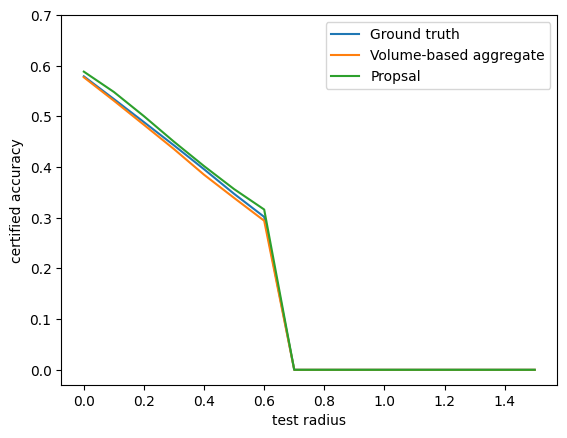

In [146]:
propsal = client_certify_acc.T @ (w / w.sum())
volume_avg = client_certify_acc.T @ (client_num)
test_radii = np.arange(0, 1.6, 0.1)
plt.plot(test_radii, server_certify_acc.detach().numpy(), label="Ground truth")
plt.plot(test_radii, volume_avg.detach().numpy(), label="Volume-based aggregate")
plt.plot(test_radii, propsal.detach().numpy(), label="Propsal")
plt.xlabel("test radius")
plt.ylabel("certified accuracy")
plt.ylim(top=0.7)
plt.legend()

In [147]:
assert False, "Idea 1 finish from here"

AssertionError: Idea 1 finish from here

# Testing from here

In [ ]:
server_labels = []
client_labels = {}
num_client = 0
client_class_num = np.zeros((10,))
cnum_client = []
option_path = '/mnt/disk1/naver/hieunguyen/provably_fl/option_logs/cifar10_cnum100_dist8_skew0.1_seed0/fedprob_N_0.25Mresnet18_R300_B10_E5_LR0.0500_P0.10_S0_LD-0.002_WD0.000_DR0.00_AC99999.00.json'

for X, Y in server.test_data:
    server_labels.append(Y)
for client in server.clients:
    client_labels[client.name] = []
    for X, Y in client.valid_data:
        client_labels[client.name].append(Y.item())
    num_client += len(client_labels[client.name])
    class_num, bins = np.histogram(client_labels[client.name], range=[0, 10])
    cnum_client.append(class_num)
    client_class_num += class_num

num_server = len(server_labels)

server_class_num, bins = np.histogram(server_labels)

records = os.listdir(option_path)
record_server = "Server.csv"
record_clients = os.listdir(option_path)
record_clients.remove(record_server)

test_radii = np.arange(0, 1.6, 0.1)


def process_result(radii, record, labels, num_classes=10):
    results = np.zeros((len(radii), num_classes))
    radius = record['radius'].tolist()
    correct = record['correct'].tolist()
    for i in range(len(labels)):
        if "True" in correct[i]:
            results[:, labels[i]] += (radii <= radius[i]).astype(np.int32)
    return results


server_result = process_result(test_radii, pd.read_csv(
    os.path.join(option_path, record_server)), server_labels, 10)
client_results = []
test = 0
for client_name in client_labels.keys():
    client_result = process_result(test_radii,
                                   pd.read_csv(os.path.join(
                                       option_path, client_name + ".csv")),
                                   client_labels[client_name],
                                   10)
    client_results.append(client_result)

client_results = np.array(client_results)
temp = client_results.copy()
per_client_accuracy = (client_results.sum(axis=-1) /
                       np.array(cnum_client).sum(axis=1, keepdims=True)).T
client_class_results = client_results / \
    (np.expand_dims(np.array(cnum_client), axis=1).repeat(repeats=16, axis=1) + 1e-8)
client_class_results = client_class_results.sum(axis=0) / 100
client_results = np.sum(client_results, axis=0)


server_cert_result = np.sum(server_result, axis=1) / np.sum(server_class_num)
client_cert_result = np.sum(client_results, axis=1) / np.sum(client_class_num)

client_class_accs = client_results / client_class_num
# client_class_accs = client_class_results

server_class_ratio = server_class_num / np.sum(server_class_num)
client_class_ratio = client_class_num / np.sum(client_class_num)

In [ ]:
import cvxpy as cp
import torch
from cvxpylayers.torch import CvxpyLayer

# num_select_client = 50
# A = np.array(cnum_client)
# client_vols = A.sum(axis=1)
# client_sort = (-client_vols).argsort()
# selected_client = client_sort[:num_select_client]

In [ ]:
def calc_min_and_max(Cr_tch: torch.Tensor, A_tch: torch.Tensor):
    num_select_clients = Cr_tch.shape[0]
    num_classes = A_tch.shape[1]
    
    x = cp.Variable(shape=(num_select_clients, 1))
    Cr = cp.Parameter(shape=(num_select_clients, 1))
    A = cp.Parameter(shape=(num_select_clients, num_classes))
    B = torch.zeros((num_classes, 1)) + 0.1

    constraints = [x >= 0, x <= 1, cp.sum(x) == 1, A.T @ x == B]
    min_objective = cp.Minimize(Cr.T @ x)
    max_objective = cp.Maximize(Cr.T @ x)

    min_problem = cp.Problem(min_objective, constraints)
    max_problem = cp.Problem(max_objective, constraints)
    
    min_layer = CvxpyLayer(min_problem, parameters=[Cr, A], variables=[x])
    max_layer = CvxpyLayer(max_problem, parameters=[Cr, A], variables=[x])
    min_solution, = min_layer(Cr_tch, A_tch)
    max_solution, = max_layer(Cr_tch, A_tch)
    
    return min_solution, max_solution

In [ ]:
C = torch.Tensor(per_client_accuracy)
A = np.array(cnum_client)
A_matrix = torch.Tensor(A)

In [ ]:
client_id = 25
print(S_pool[client_id].detach().numpy().round(3))
print(cnum_client[client_id] / cnum_client[client_id].sum())

[0.796 0.187 0.011 0.003 0.001 0.001 0.001 0.    0.    0.   ]
[0.         0.66666667 0.         0.33333333 0.         0.
 0.         0.         0.         0.        ]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
A_matrix = torch.concat([S.unsqueeze(-1) for S in S_pool], dim=-1).T
A_matrix = A_matrix.detach().numpy()
cosine_dist = cosine_similarity(np.array(cnum_client))
cosine_svd = cosine_similarity(A_matrix)

In [ ]:
A_matrix = torch.Tensor(A_matrix)

In [ ]:
min_cert = []
max_cert = []
mean_cert = []
for i in range(test_radii.shape[0]):
    Cr_tch = C[i].unsqueeze(-1)
    A_tch = A_matrix / torch.sum(A_matrix, dim=1, keepdim=True)
    A_tch = torch.Tensor(A_tch)

    min_solution, max_solution = calc_min_and_max(Cr_tch, A_tch)
    min_optima = Cr_tch.T @ min_solution
    max_optima = Cr_tch.T @ max_solution
    
    min_cert.append(min_optima.item())
    max_cert.append(max_optima.item())
    mean_cert.append((min_cert[i] + max_cert[i]) / 2)

Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.


SolverError: Solver scs returned status infeasible

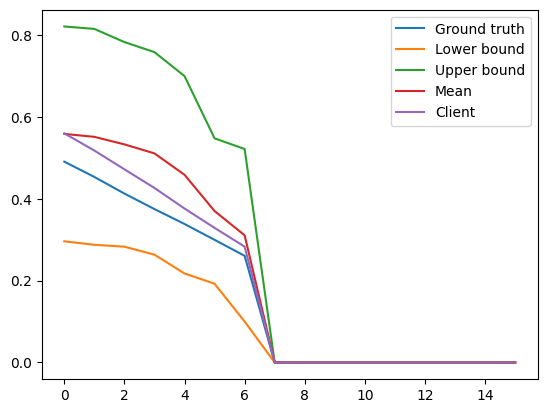

In [ ]:
plt.plot(server_cert_result, label="Ground truth")
plt.plot(min_cert, label="Lower bound")
plt.plot(max_cert, label="Upper bound")
plt.plot(mean_cert, label="Mean")
plt.plot(client_cert_result, label="Client")
plt.legend()